# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [3]:
# detection parameters
to_localize = False
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [5]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization Off
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 75

In [6]:
H.LoadDetected()

Detected and read 19341 spikes.


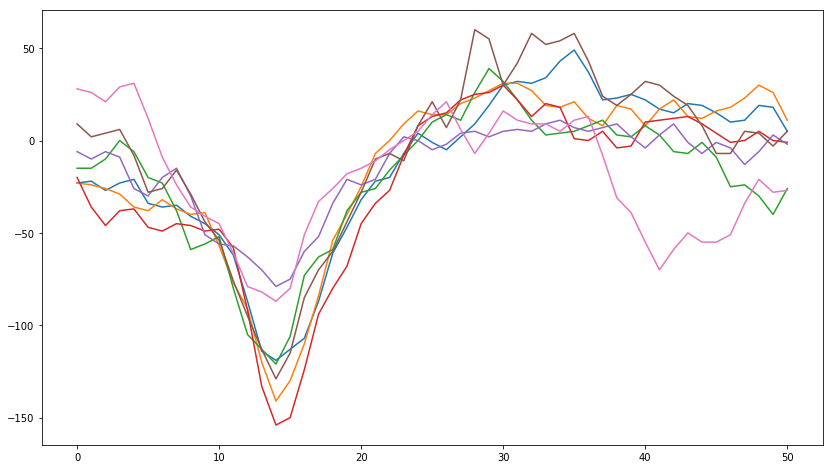

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,8))
for i in [11, 290, 3490, 1098, 2707, 9, 871]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(19341, 51)


In [9]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=12)
# pca.fit(electrode_data)
# e_data_pca = pca.transform(electrode_data_train)
# e_data_proj = pca.inverse_transform(e_data_pca)

In [10]:
# plt.figure(figsize=(14,4))

# n = [3490, 1098, 2377, 9, 871]

# for i in n:
#     plt.subplot(121)
#     plt.plot(electrode_data_test[i, :])
#     plt.title('Original')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(122)
#     plt.plot(e_data_proj[i, :])
#     plt.title('PCA reconstruction')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
# plt.show()

## Scaling data between 0 and 1

In [11]:
# electrode_data = electrode_data_temp[:, :]

In [12]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [13]:
print(electrode_data)

[[ -7.  -2.   4. ...   7.   7.   9.]
 [ 35.  33.  26. ...   0.  -7. -10.]
 [ 15.  16.   8. ... -11.  -1.   1.]
 ...
 [ -2. -19. -23. ...  -7. -15. -31.]
 [ 12.   0.  -3. ...  -8. -10.  -5.]
 [-20. -32. -29. ...   9.   0.  -9.]]


## Designing the AutoEncoder 

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [15]:
class lstm_autoencoder(nn.Module):
    def __init__(self, input_size, seq_len, embedding_size):
        super(lstm_autoencoder, self).__init__()
        if input_size%seq_len != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.PReLU()
        
        first_lin_size = 28*(input_size//seq_len)
        
        self.lstm1 = nn.LSTM(input_size=seq_len, hidden_size=15, num_layers=2)
        self.lstm2 = nn.LSTM(input_size=15, hidden_size=28, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, 80)
        self.lin2 = nn.Linear(80, embedding_size)
        
        self.lin3 = nn.Linear(embedding_size, 16)
        self.lin4 = nn.Linear(16, 25)
        self.lin5 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        x = self.serialise_input(x, 3)
        out, _ = self.lstm1(x, hidden)
        out, _ = self.lstm2(out, hidden)
        out = self.flatten_input(out)
        out = self.lin1(out)
        out = self.activation_layer(out)
        enc = self.lin2(out)

        out = self.lin3(enc)
        out = self.activation_layer(out)
        out = self.lin4(out)
        out = self.activation_layer(out)
        dec = self.lin5(out)
        return enc, dec
    
    def serialise_input(self, data, seq_len):
        data = data.view(-1, 1, seq_len)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [16]:
# class lstm_autoencoder(nn.Module):
#     def __init__(self, input_size, embedding_size):
#         super(lstm_autoencoder, self).__init__()
#         activation_layer = nn.PReLU()
#         self.encoder = nn.Sequential(nn.LSTMCell(input_size=input_size, hidden_size=75),
#                                      activation_layer,
#                                      nn.LSTMCell(input_size=75, hidden_size=28),
#                                      activation_layer,
#                                      nn.Linear(28, embedding_size))
#         self.decoder = nn.Sequential(nn.LSTMCell(input_size=embedding_size, hidden_size=16),
#                                      activation_layer,
#                                      nn.LSTMCell(input_size=16, hidden_size=25),
#                                      activation_layer,
#                                      nn.Linear(25, input_size))    
#     def forward(self, x):
#         enc = self.encoder(x)
#         dec = self.decoder(enc)
#         return enc, dec

## Splitting the data into Train and Test

In [17]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [18]:
random.seed(0)

def train_lstm(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [19]:
def init_lstm_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
    elif type(layer) == nn.LSTM:
        for name, param in layer.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal(param)

## Training with embedding size = 12

In [20]:
epoch_range = 2000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 12

lstm_ae_1 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_1.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_1 = train_lstm(lstm_ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/2000], loss:2515.18359, avg:2515.18359
epoch [2/2000], loss:1096.37500, avg:1805.77930
epoch [3/2000], loss:827.74664, avg:1479.76843
epoch [4/2000], loss:185.18675, avg:1156.12292
epoch [5/2000], loss:172.30606, avg:959.35956
epoch [6/2000], loss:139.57217, avg:822.72833
epoch [7/2000], loss:1017.70911, avg:850.58270
epoch [8/2000], loss:207.38019, avg:770.18243
epoch [9/2000], loss:496.22836, avg:739.74310
epoch [10/2000], loss:982.37872, avg:764.00671
epoch [11/2000], loss:90.33350, avg:521.52167
epoch [12/2000], loss:213.70695, avg:433.25482
epoch [13/2000], loss:87.54450, avg:359.23462
epoch [14/2000], loss:49.63187, avg:345.67914
epoch [15/2000], loss:392.66797, avg:367.71533
epoch [16/2000], loss:285.95648, avg:382.35379
epoch [17/2000], loss:90.21619, avg:289.60449
epoch [18/2000], loss:394.59250, avg:308.32571
epoch [19/2000], loss:95.76361, avg:268.27924
epoch [20/2000], loss:120.83675, avg:182.12503
epoch [21/2000], loss:436.92596, avg:216.78427
epoch [22/2000], los

epoch [175/2000], loss:62.57031, avg:140.91887
epoch [176/2000], loss:102.98546, avg:143.74858
epoch [177/2000], loss:63.92146, avg:136.74219
epoch [178/2000], loss:223.14513, avg:147.62939
epoch [179/2000], loss:157.22270, avg:147.64731
epoch [180/2000], loss:137.82367, avg:143.33566
epoch [181/2000], loss:50.93592, avg:141.85065
epoch [182/2000], loss:220.19208, avg:137.92847
epoch [183/2000], loss:89.97791, avg:128.40831
epoch [184/2000], loss:71.88065, avg:118.06553
epoch [185/2000], loss:180.23068, avg:129.83157
epoch [186/2000], loss:873.69196, avg:206.90222
epoch [187/2000], loss:94.74895, avg:209.98499
epoch [188/2000], loss:139.63622, avg:201.63406
epoch [189/2000], loss:177.17471, avg:203.62927
epoch [190/2000], loss:315.87985, avg:221.43489
epoch [191/2000], loss:95.29353, avg:225.87064
epoch [192/2000], loss:57.13869, avg:209.56534
epoch [193/2000], loss:113.76609, avg:211.94412
epoch [194/2000], loss:50.43977, avg:209.80005
epoch [195/2000], loss:102.73470, avg:202.05046
e

epoch [349/2000], loss:102.41167, avg:110.54492
epoch [350/2000], loss:65.48608, avg:99.25221
epoch [351/2000], loss:57.63230, avg:98.07713
epoch [352/2000], loss:53.00404, avg:96.30586
epoch [353/2000], loss:109.77180, avg:99.13216
epoch [354/2000], loss:107.82348, avg:93.38053
epoch [355/2000], loss:42.71854, avg:89.70983
epoch [356/2000], loss:61.24232, avg:72.52360
epoch [357/2000], loss:44.17478, avg:70.08782
epoch [358/2000], loss:174.38745, avg:81.86525
epoch [359/2000], loss:76.41069, avg:79.26515
epoch [360/2000], loss:53.88460, avg:78.10500
epoch [361/2000], loss:42.72969, avg:76.61474
epoch [362/2000], loss:150.32236, avg:86.34657
epoch [363/2000], loss:75.36975, avg:82.90636
epoch [364/2000], loss:101.27962, avg:82.25198
epoch [365/2000], loss:65.32434, avg:84.51257
epoch [366/2000], loss:143.17343, avg:92.70567
epoch [367/2000], loss:226.11414, avg:110.89961
epoch [368/2000], loss:41.71728, avg:97.63259
epoch [369/2000], loss:108.57474, avg:100.84900
epoch [370/2000], loss

epoch [525/2000], loss:41.87962, avg:81.74310
epoch [526/2000], loss:60.96618, avg:76.20364
epoch [527/2000], loss:69.76421, avg:73.91810
epoch [528/2000], loss:40.31327, avg:73.15784
epoch [529/2000], loss:52.30886, avg:64.90113
epoch [530/2000], loss:88.99961, avg:68.56911
epoch [531/2000], loss:97.15762, avg:73.44822
epoch [532/2000], loss:71.97682, avg:69.14658
epoch [533/2000], loss:69.53605, avg:65.16879
epoch [534/2000], loss:139.51884, avg:73.24211
epoch [535/2000], loss:59.41399, avg:74.99555
epoch [536/2000], loss:30.50039, avg:71.94896
epoch [537/2000], loss:66.42423, avg:71.61497
epoch [538/2000], loss:82.54556, avg:75.83820
epoch [539/2000], loss:55.15522, avg:76.12283
epoch [540/2000], loss:46.20729, avg:71.84360
epoch [541/2000], loss:266.95755, avg:88.82359
epoch [542/2000], loss:81.76724, avg:89.80264
epoch [543/2000], loss:71.11119, avg:89.96016
epoch [544/2000], loss:62.25616, avg:82.23388
epoch [545/2000], loss:53.36345, avg:81.62883
epoch [546/2000], loss:96.24733,

epoch [703/2000], loss:40.66068, avg:57.02901
epoch [704/2000], loss:39.00026, avg:54.49269
epoch [705/2000], loss:98.56840, avg:57.34478
epoch [706/2000], loss:276.47308, avg:76.39491
epoch [707/2000], loss:90.54057, avg:80.34790
epoch [708/2000], loss:46.34954, avg:76.49727
epoch [709/2000], loss:105.01724, avg:82.15987
epoch [710/2000], loss:63.24835, avg:85.08381
epoch [711/2000], loss:32.10551, avg:83.79883
epoch [712/2000], loss:46.73191, avg:83.86955
epoch [713/2000], loss:94.33273, avg:89.23677
epoch [714/2000], loss:57.02240, avg:91.03899
epoch [715/2000], loss:33.75575, avg:84.55772
epoch [716/2000], loss:47.05610, avg:61.61601
epoch [717/2000], loss:57.29696, avg:58.29165
epoch [718/2000], loss:45.28774, avg:58.18547
epoch [719/2000], loss:75.08096, avg:55.19184
epoch [720/2000], loss:34.02938, avg:52.26995
epoch [721/2000], loss:52.43297, avg:54.30269
epoch [722/2000], loss:41.88826, avg:53.81832
epoch [723/2000], loss:79.92168, avg:52.37722
epoch [724/2000], loss:64.24937,

epoch [881/2000], loss:28.07457, avg:54.53889
epoch [882/2000], loss:25.78546, avg:42.73995
epoch [883/2000], loss:74.39075, avg:45.39339
epoch [884/2000], loss:83.46266, avg:47.13551
epoch [885/2000], loss:32.01574, avg:47.09211
epoch [886/2000], loss:39.94500, avg:46.73064
epoch [887/2000], loss:51.77429, avg:46.26717
epoch [888/2000], loss:38.06980, avg:45.86026
epoch [889/2000], loss:62.77519, avg:48.74841
epoch [890/2000], loss:122.62679, avg:55.89202
epoch [891/2000], loss:62.94258, avg:59.37882
epoch [892/2000], loss:74.59342, avg:64.25962
epoch [893/2000], loss:54.47266, avg:62.26781
epoch [894/2000], loss:24.97768, avg:56.41932
epoch [895/2000], loss:67.95750, avg:60.01350
epoch [896/2000], loss:79.21611, avg:63.94061
epoch [897/2000], loss:25.38745, avg:61.30192
epoch [898/2000], loss:48.86538, avg:62.38148
epoch [899/2000], loss:95.98766, avg:65.70273
epoch [900/2000], loss:42.00661, avg:57.64071
epoch [901/2000], loss:329.46826, avg:84.29327
epoch [902/2000], loss:74.45871,

epoch [1058/2000], loss:24.42997, avg:40.96059
epoch [1059/2000], loss:53.84275, avg:41.81860
epoch [1060/2000], loss:48.42050, avg:42.39729
epoch [1061/2000], loss:92.68542, avg:47.29450
epoch [1062/2000], loss:46.77909, avg:47.87121
epoch [1063/2000], loss:44.55411, avg:48.54716
epoch [1064/2000], loss:38.46683, avg:45.65179
epoch [1065/2000], loss:61.07217, avg:48.65721
epoch [1066/2000], loss:29.50397, avg:48.55201
epoch [1067/2000], loss:23.45615, avg:46.32110
epoch [1068/2000], loss:70.70042, avg:50.94814
epoch [1069/2000], loss:29.51793, avg:48.51566
epoch [1070/2000], loss:44.03957, avg:48.07757
epoch [1071/2000], loss:60.89567, avg:44.89859
epoch [1072/2000], loss:36.14676, avg:43.83536
epoch [1073/2000], loss:64.56699, avg:45.83664
epoch [1074/2000], loss:26.18654, avg:44.60862
epoch [1075/2000], loss:36.95312, avg:42.19671
epoch [1076/2000], loss:52.57221, avg:44.50354
epoch [1077/2000], loss:23.88911, avg:44.54683
epoch [1078/2000], loss:33.04785, avg:40.78157
epoch [1079/2

epoch [1233/2000], loss:55.91286, avg:54.91449
epoch [1234/2000], loss:34.80778, avg:53.70039
epoch [1235/2000], loss:57.44822, avg:42.76439
epoch [1236/2000], loss:36.90945, avg:42.09046
epoch [1237/2000], loss:25.29572, avg:40.58502
epoch [1238/2000], loss:15.97520, avg:37.52559
epoch [1239/2000], loss:49.90678, avg:38.20611
epoch [1240/2000], loss:54.53755, avg:40.87762
epoch [1241/2000], loss:33.88237, avg:41.63303
epoch [1242/2000], loss:44.29363, avg:40.89695
epoch [1243/2000], loss:39.17227, avg:39.22290
epoch [1244/2000], loss:54.96201, avg:41.23832
epoch [1245/2000], loss:42.92874, avg:39.78637
epoch [1246/2000], loss:78.51439, avg:43.94687
epoch [1247/2000], loss:53.63094, avg:46.78038
epoch [1248/2000], loss:21.33966, avg:47.31683
epoch [1249/2000], loss:30.04434, avg:45.33059
epoch [1250/2000], loss:43.44883, avg:44.22172
epoch [1251/2000], loss:30.64643, avg:43.89812
epoch [1252/2000], loss:70.86845, avg:46.55560
epoch [1253/2000], loss:85.91235, avg:51.22961
epoch [1254/2

epoch [1408/2000], loss:81.62695, avg:48.96896
epoch [1409/2000], loss:58.80067, avg:49.76682
epoch [1410/2000], loss:48.48651, avg:48.59256
epoch [1411/2000], loss:41.47199, avg:48.18883
epoch [1412/2000], loss:35.73110, avg:47.45302
epoch [1413/2000], loss:35.10488, avg:48.06956
epoch [1414/2000], loss:26.52418, avg:45.40289
epoch [1415/2000], loss:36.86866, avg:43.00060
epoch [1416/2000], loss:79.94413, avg:46.54746
epoch [1417/2000], loss:48.93005, avg:49.34891
epoch [1418/2000], loss:29.34474, avg:44.12069
epoch [1419/2000], loss:39.95018, avg:42.23565
epoch [1420/2000], loss:36.04177, avg:40.99117
epoch [1421/2000], loss:36.55273, avg:40.49924
epoch [1422/2000], loss:52.12370, avg:42.13850
epoch [1423/2000], loss:54.58143, avg:44.08616
epoch [1424/2000], loss:50.32534, avg:46.46627
epoch [1425/2000], loss:28.40373, avg:45.61978
epoch [1426/2000], loss:46.84439, avg:42.30981
epoch [1427/2000], loss:29.37892, avg:40.35469
epoch [1428/2000], loss:43.01400, avg:41.72162
epoch [1429/2

epoch [1583/2000], loss:34.46048, avg:41.59321
epoch [1584/2000], loss:41.48510, avg:42.52253
epoch [1585/2000], loss:37.83295, avg:42.08438
epoch [1586/2000], loss:33.72309, avg:39.35105
epoch [1587/2000], loss:39.57499, avg:41.05371
epoch [1588/2000], loss:27.46043, avg:38.63448
epoch [1589/2000], loss:41.99509, avg:39.89526
epoch [1590/2000], loss:20.38147, avg:38.56783
epoch [1591/2000], loss:67.97792, avg:39.12867
epoch [1592/2000], loss:72.11857, avg:41.70101
epoch [1593/2000], loss:28.78300, avg:41.13326
epoch [1594/2000], loss:56.72084, avg:42.65684
epoch [1595/2000], loss:33.22208, avg:42.19575
epoch [1596/2000], loss:43.50404, avg:43.17384
epoch [1597/2000], loss:38.75870, avg:43.09221
epoch [1598/2000], loss:46.32966, avg:44.97913
epoch [1599/2000], loss:21.48125, avg:42.92775
epoch [1600/2000], loss:35.38070, avg:44.42768
epoch [1601/2000], loss:35.67524, avg:41.19741
epoch [1602/2000], loss:35.38240, avg:37.52379
epoch [1603/2000], loss:42.17202, avg:38.86269
epoch [1604/2

epoch [1758/2000], loss:45.68090, avg:44.90686
epoch [1759/2000], loss:51.10039, avg:46.55720
epoch [1760/2000], loss:27.94801, avg:42.40503
epoch [1761/2000], loss:38.75972, avg:43.06762
epoch [1762/2000], loss:39.19461, avg:44.01305
epoch [1763/2000], loss:52.20349, avg:46.17316
epoch [1764/2000], loss:40.94903, avg:44.24489
epoch [1765/2000], loss:39.10347, avg:44.25159
epoch [1766/2000], loss:27.12604, avg:41.22236
epoch [1767/2000], loss:25.60934, avg:38.76750
epoch [1768/2000], loss:26.51917, avg:36.85133
epoch [1769/2000], loss:53.49348, avg:37.09064
epoch [1770/2000], loss:45.69753, avg:38.86559
epoch [1771/2000], loss:43.95476, avg:39.38509
epoch [1772/2000], loss:34.71510, avg:38.93714
epoch [1773/2000], loss:45.75148, avg:38.29194
epoch [1774/2000], loss:48.18706, avg:39.01575
epoch [1775/2000], loss:32.97915, avg:38.40331
epoch [1776/2000], loss:56.77015, avg:41.36773
epoch [1777/2000], loss:36.83782, avg:42.49057
epoch [1778/2000], loss:44.59357, avg:44.29801
epoch [1779/2

epoch [1933/2000], loss:84.01509, avg:47.96601
epoch [1934/2000], loss:26.57932, avg:46.97838
epoch [1935/2000], loss:38.41459, avg:46.14265
epoch [1936/2000], loss:34.57294, avg:46.16999
epoch [1937/2000], loss:23.76974, avg:45.03285
epoch [1938/2000], loss:34.43209, avg:43.31901
epoch [1939/2000], loss:22.76220, avg:40.18001
epoch [1940/2000], loss:53.00729, avg:40.43740
epoch [1941/2000], loss:73.78709, avg:43.72942
epoch [1942/2000], loss:34.27271, avg:42.56130
epoch [1943/2000], loss:59.28345, avg:40.08814
epoch [1944/2000], loss:43.63132, avg:41.79334
epoch [1945/2000], loss:28.28544, avg:40.78042
epoch [1946/2000], loss:34.21697, avg:40.74483
epoch [1947/2000], loss:36.00455, avg:41.96831
epoch [1948/2000], loss:48.12305, avg:43.33741
epoch [1949/2000], loss:35.47327, avg:44.60851
epoch [1950/2000], loss:37.64563, avg:43.07235
epoch [1951/2000], loss:56.31508, avg:41.32515
epoch [1952/2000], loss:31.78118, avg:41.07600
epoch [1953/2000], loss:21.42663, avg:37.29031
epoch [1954/2

In [21]:
torch.save(lstm_ae_1, 'models/visapy/lstm_12.pt') #Saving the autoencoder model

## Loss Plot and Reconstruction

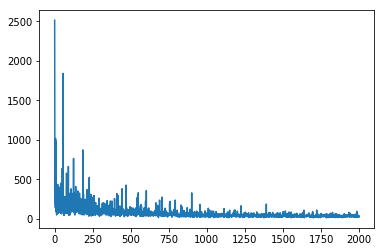

In [22]:
plt.figure()
plt.plot(losses_1)
plt.show()

## Training with embedding size = 10

In [23]:
epoch_range = 2000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 10

lstm_ae_2 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_2.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_2.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_2 = train_lstm(lstm_ae_2, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/2000], loss:3706.10620, avg:3706.10620
epoch [2/2000], loss:1241.28723, avg:2473.69678
epoch [3/2000], loss:258.10715, avg:1735.16687
epoch [4/2000], loss:311.67899, avg:1379.29492
epoch [5/2000], loss:182.88974, avg:1140.01392
epoch [6/2000], loss:150.07747, avg:975.02448
epoch [7/2000], loss:194.54892, avg:863.52795
epoch [8/2000], loss:486.56940, avg:816.40814
epoch [9/2000], loss:254.21913, avg:753.94269
epoch [10/2000], loss:166.55090, avg:695.20349
epoch [11/2000], loss:349.96689, avg:359.58954
epoch [12/2000], loss:323.73898, avg:267.83475
epoch [13/2000], loss:188.40688, avg:260.86472
epoch [14/2000], loss:132.68227, avg:242.96509
epoch [15/2000], loss:270.12744, avg:251.68884
epoch [16/2000], loss:69.96889, avg:243.67798
epoch [17/2000], loss:84.36474, avg:232.65955
epoch [18/2000], loss:229.25954, avg:206.92856
epoch [19/2000], loss:293.67188, avg:210.87383
epoch [20/2000], loss:156.77855, avg:209.89658
epoch [21/2000], loss:450.82001, avg:219.98190
epoch [22/2000], 

epoch [175/2000], loss:50.15109, avg:194.37418
epoch [176/2000], loss:194.41002, avg:200.66945
epoch [177/2000], loss:132.68253, avg:202.06351
epoch [178/2000], loss:267.19968, avg:201.79434
epoch [179/2000], loss:202.24211, avg:210.15073
epoch [180/2000], loss:161.94019, avg:201.19283
epoch [181/2000], loss:167.81760, avg:191.71094
epoch [182/2000], loss:420.88361, avg:199.00691
epoch [183/2000], loss:186.39961, avg:192.82596
epoch [184/2000], loss:258.78137, avg:204.25079
epoch [185/2000], loss:159.65816, avg:215.20149
epoch [186/2000], loss:543.11572, avg:250.07207
epoch [187/2000], loss:164.51562, avg:253.25537
epoch [188/2000], loss:126.22569, avg:239.15796
epoch [189/2000], loss:271.11203, avg:246.04495
epoch [190/2000], loss:235.85294, avg:253.43623
epoch [191/2000], loss:171.33058, avg:253.78755
epoch [192/2000], loss:305.18686, avg:242.21785
epoch [193/2000], loss:384.66995, avg:262.04486
epoch [194/2000], loss:310.87280, avg:267.25403
epoch [195/2000], loss:176.11705, avg:268

epoch [348/2000], loss:33.34436, avg:142.65506
epoch [349/2000], loss:143.35419, avg:138.80374
epoch [350/2000], loss:44.44596, avg:131.08324
epoch [351/2000], loss:70.17718, avg:124.83813
epoch [352/2000], loss:88.43233, avg:121.96643
epoch [353/2000], loss:58.45315, avg:116.71503
epoch [354/2000], loss:147.75989, avg:125.33092
epoch [355/2000], loss:73.36767, avg:122.36757
epoch [356/2000], loss:79.36250, avg:120.08675
epoch [357/2000], loss:55.52588, avg:79.42231
epoch [358/2000], loss:155.35004, avg:91.62288
epoch [359/2000], loss:103.71078, avg:87.65853
epoch [360/2000], loss:93.27059, avg:92.54100
epoch [361/2000], loss:153.68660, avg:100.89194
epoch [362/2000], loss:93.08928, avg:101.35764
epoch [363/2000], loss:105.11940, avg:106.02427
epoch [364/2000], loss:92.57655, avg:100.50593
epoch [365/2000], loss:61.17398, avg:99.28656
epoch [366/2000], loss:56.68464, avg:97.01878
epoch [367/2000], loss:64.37103, avg:97.90329
epoch [368/2000], loss:53.63028, avg:87.73132
epoch [369/2000

epoch [525/2000], loss:74.68175, avg:90.81763
epoch [526/2000], loss:69.26466, avg:87.64649
epoch [527/2000], loss:81.16324, avg:84.66591
epoch [528/2000], loss:90.85337, avg:86.54380
epoch [529/2000], loss:79.83559, avg:84.31310
epoch [530/2000], loss:218.69983, avg:94.86696
epoch [531/2000], loss:63.70425, avg:93.18872
epoch [532/2000], loss:130.10892, avg:99.96584
epoch [533/2000], loss:50.94724, avg:92.76404
epoch [534/2000], loss:81.07911, avg:94.03379
epoch [535/2000], loss:116.69748, avg:98.23537
epoch [536/2000], loss:102.18539, avg:101.52744
epoch [537/2000], loss:40.08681, avg:97.41980
epoch [538/2000], loss:55.75948, avg:93.91041
epoch [539/2000], loss:95.75452, avg:95.50230
epoch [540/2000], loss:99.01146, avg:83.53346
epoch [541/2000], loss:57.17949, avg:82.88099
epoch [542/2000], loss:76.83706, avg:77.55380
epoch [543/2000], loss:31.03818, avg:75.56290
epoch [544/2000], loss:50.13918, avg:72.46891
epoch [545/2000], loss:72.70757, avg:68.06992
epoch [546/2000], loss:32.332

epoch [703/2000], loss:47.95600, avg:52.73416
epoch [704/2000], loss:60.30968, avg:53.13844
epoch [705/2000], loss:49.59535, avg:55.35633
epoch [706/2000], loss:276.33237, avg:78.96954
epoch [707/2000], loss:117.70961, avg:84.22390
epoch [708/2000], loss:71.12807, avg:87.14789
epoch [709/2000], loss:193.07451, avg:102.02115
epoch [710/2000], loss:53.71629, avg:96.96349
epoch [711/2000], loss:42.01340, avg:94.99547
epoch [712/2000], loss:90.14148, avg:100.19768
epoch [713/2000], loss:67.22811, avg:102.12489
epoch [714/2000], loss:43.43288, avg:100.43720
epoch [715/2000], loss:47.31180, avg:100.20885
epoch [716/2000], loss:45.14343, avg:77.08995
epoch [717/2000], loss:64.17155, avg:71.73615
epoch [718/2000], loss:83.46895, avg:72.97024
epoch [719/2000], loss:41.01968, avg:57.76475
epoch [720/2000], loss:38.32121, avg:56.22525
epoch [721/2000], loss:27.51461, avg:54.77537
epoch [722/2000], loss:40.77370, avg:49.83859
epoch [723/2000], loss:103.40391, avg:53.45618
epoch [724/2000], loss:86

epoch [881/2000], loss:34.38343, avg:53.35133
epoch [882/2000], loss:60.68528, avg:55.34555
epoch [883/2000], loss:118.62910, avg:61.82338
epoch [884/2000], loss:37.97626, avg:61.44270
epoch [885/2000], loss:47.26862, avg:61.22751
epoch [886/2000], loss:44.18900, avg:61.30940
epoch [887/2000], loss:76.46134, avg:55.58463
epoch [888/2000], loss:40.44144, avg:52.70209
epoch [889/2000], loss:111.86819, avg:61.97884
epoch [890/2000], loss:30.70120, avg:60.26038
epoch [891/2000], loss:61.54660, avg:62.97670
epoch [892/2000], loss:69.78104, avg:63.88628
epoch [893/2000], loss:64.56171, avg:58.47954
epoch [894/2000], loss:166.29141, avg:71.31105
epoch [895/2000], loss:39.72450, avg:70.55664
epoch [896/2000], loss:50.98144, avg:71.23589
epoch [897/2000], loss:29.06382, avg:66.49614
epoch [898/2000], loss:49.29427, avg:67.38142
epoch [899/2000], loss:57.82671, avg:61.97727
epoch [900/2000], loss:54.63699, avg:64.37085
epoch [901/2000], loss:35.10985, avg:61.72717
epoch [902/2000], loss:40.42710

epoch [1058/2000], loss:36.14731, avg:40.87070
epoch [1059/2000], loss:35.12928, avg:40.97744
epoch [1060/2000], loss:33.65984, avg:40.05337
epoch [1061/2000], loss:49.72740, avg:43.01101
epoch [1062/2000], loss:29.92605, avg:42.42667
epoch [1063/2000], loss:35.55699, avg:43.21838
epoch [1064/2000], loss:33.23446, avg:37.57325
epoch [1065/2000], loss:52.00576, avg:39.59000
epoch [1066/2000], loss:105.37650, avg:46.24632
epoch [1067/2000], loss:66.75813, avg:47.75217
epoch [1068/2000], loss:42.60434, avg:48.39787
epoch [1069/2000], loss:84.79495, avg:53.36444
epoch [1070/2000], loss:50.32350, avg:55.03081
epoch [1071/2000], loss:60.12584, avg:56.07066
epoch [1072/2000], loss:67.92579, avg:59.87062
epoch [1073/2000], loss:35.97729, avg:59.91266
epoch [1074/2000], loss:43.37316, avg:60.92653
epoch [1075/2000], loss:39.09430, avg:59.63538
epoch [1076/2000], loss:19.72393, avg:51.07012
epoch [1077/2000], loss:78.81373, avg:52.27568
epoch [1078/2000], loss:39.45533, avg:51.96078
epoch [1079/

epoch [1233/2000], loss:25.01842, avg:47.73649
epoch [1234/2000], loss:32.83256, avg:46.98147
epoch [1235/2000], loss:52.34277, avg:44.43452
epoch [1236/2000], loss:107.67945, avg:50.82038
epoch [1237/2000], loss:30.12746, avg:46.93978
epoch [1238/2000], loss:42.49358, avg:47.68862
epoch [1239/2000], loss:27.75639, avg:45.41245
epoch [1240/2000], loss:60.24836, avg:49.18365
epoch [1241/2000], loss:32.58482, avg:48.55056
epoch [1242/2000], loss:33.23692, avg:44.43207
epoch [1243/2000], loss:77.95608, avg:49.72584
epoch [1244/2000], loss:30.97547, avg:49.54012
epoch [1245/2000], loss:31.95243, avg:47.50109
epoch [1246/2000], loss:33.13958, avg:40.04711
epoch [1247/2000], loss:52.28732, avg:42.26310
epoch [1248/2000], loss:30.06190, avg:41.01992
epoch [1249/2000], loss:32.39024, avg:41.48331
epoch [1250/2000], loss:73.32268, avg:42.79074
epoch [1251/2000], loss:42.14180, avg:43.74644
epoch [1252/2000], loss:36.58247, avg:44.08099
epoch [1253/2000], loss:25.45814, avg:38.83120
epoch [1254/

epoch [1408/2000], loss:43.73830, avg:44.31793
epoch [1409/2000], loss:49.30580, avg:45.70406
epoch [1410/2000], loss:42.36262, avg:41.57794
epoch [1411/2000], loss:45.00115, avg:42.44814
epoch [1412/2000], loss:39.30206, avg:42.26920
epoch [1413/2000], loss:31.95303, avg:42.64484
epoch [1414/2000], loss:35.06753, avg:42.08651
epoch [1415/2000], loss:48.89279, avg:41.64673
epoch [1416/2000], loss:53.68748, avg:42.52291
epoch [1417/2000], loss:64.75934, avg:45.40701
epoch [1418/2000], loss:24.63756, avg:43.49694
epoch [1419/2000], loss:26.61950, avg:41.22831
epoch [1420/2000], loss:22.19381, avg:39.21143
epoch [1421/2000], loss:34.28458, avg:38.13977
epoch [1422/2000], loss:56.58085, avg:39.86765
epoch [1423/2000], loss:30.00651, avg:39.67299
epoch [1424/2000], loss:47.59016, avg:40.92525
epoch [1425/2000], loss:86.35851, avg:44.67183
epoch [1426/2000], loss:43.56800, avg:43.65988
epoch [1427/2000], loss:41.84872, avg:41.36882
epoch [1428/2000], loss:45.67457, avg:43.47252
epoch [1429/2

epoch [1583/2000], loss:31.88256, avg:39.78777
epoch [1584/2000], loss:53.47335, avg:38.91439
epoch [1585/2000], loss:26.35160, avg:37.01988
epoch [1586/2000], loss:41.28354, avg:34.48902
epoch [1587/2000], loss:30.71988, avg:34.56164
epoch [1588/2000], loss:41.58656, avg:35.16188
epoch [1589/2000], loss:35.72443, avg:36.08270
epoch [1590/2000], loss:56.43451, avg:36.34727
epoch [1591/2000], loss:37.87019, avg:37.91329
epoch [1592/2000], loss:49.89672, avg:40.52233
epoch [1593/2000], loss:41.21378, avg:41.45545
epoch [1594/2000], loss:18.52367, avg:37.96049
epoch [1595/2000], loss:38.41568, avg:39.16690
epoch [1596/2000], loss:17.97795, avg:36.83633
epoch [1597/2000], loss:39.59320, avg:37.72367
epoch [1598/2000], loss:28.06975, avg:36.37199
epoch [1599/2000], loss:53.87625, avg:38.18717
epoch [1600/2000], loss:28.70444, avg:35.41416
epoch [1601/2000], loss:29.86704, avg:34.61385
epoch [1602/2000], loss:39.67423, avg:33.59160
epoch [1603/2000], loss:55.14390, avg:34.98461
epoch [1604/2

epoch [1758/2000], loss:64.24272, avg:37.66647
epoch [1759/2000], loss:48.69607, avg:38.75430
epoch [1760/2000], loss:44.70435, avg:39.73055
epoch [1761/2000], loss:38.36184, avg:39.92553
epoch [1762/2000], loss:49.37191, avg:42.68249
epoch [1763/2000], loss:23.67360, avg:39.62920
epoch [1764/2000], loss:42.37317, avg:40.75365
epoch [1765/2000], loss:31.46796, avg:41.02534
epoch [1766/2000], loss:28.31753, avg:41.19256
epoch [1767/2000], loss:52.17767, avg:42.33868
epoch [1768/2000], loss:39.01235, avg:39.81565
epoch [1769/2000], loss:28.54606, avg:37.80064
epoch [1770/2000], loss:47.23717, avg:38.05393
epoch [1771/2000], loss:34.80013, avg:37.69776
epoch [1772/2000], loss:38.05262, avg:36.56583
epoch [1773/2000], loss:24.04078, avg:36.60255
epoch [1774/2000], loss:40.39830, avg:36.40506
epoch [1775/2000], loss:29.64756, avg:36.22301
epoch [1776/2000], loss:40.78508, avg:37.46977
epoch [1777/2000], loss:57.44620, avg:37.99662
epoch [1778/2000], loss:91.03347, avg:43.19874
epoch [1779/2

epoch [1933/2000], loss:43.49930, avg:44.86816
epoch [1934/2000], loss:29.38960, avg:41.25922
epoch [1935/2000], loss:30.48301, avg:41.10441
epoch [1936/2000], loss:54.66078, avg:42.39610
epoch [1937/2000], loss:21.16710, avg:39.47289
epoch [1938/2000], loss:45.46396, avg:40.19980
epoch [1939/2000], loss:19.60711, avg:37.16396
epoch [1940/2000], loss:35.04684, avg:35.49751
epoch [1941/2000], loss:24.69070, avg:34.56941
epoch [1942/2000], loss:30.13594, avg:33.41444
epoch [1943/2000], loss:44.96441, avg:33.56094
epoch [1944/2000], loss:35.31793, avg:34.15378
epoch [1945/2000], loss:51.52665, avg:36.25814
epoch [1946/2000], loss:28.01591, avg:33.59365
epoch [1947/2000], loss:23.09206, avg:33.78615
epoch [1948/2000], loss:72.32090, avg:36.47184
epoch [1949/2000], loss:32.14326, avg:37.72546
epoch [1950/2000], loss:24.59009, avg:36.67978
epoch [1951/2000], loss:40.28516, avg:38.23923
epoch [1952/2000], loss:38.10378, avg:39.03601
epoch [1953/2000], loss:40.00252, avg:38.53983
epoch [1954/2

In [24]:
torch.save(lstm_ae_2, 'models/visapy/lstm_10.pt') #Saving the autoencoder model

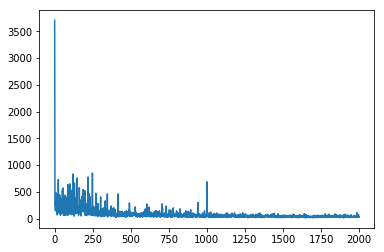

In [25]:
plt.figure()
plt.plot(losses_2)
plt.show()

## Training with embedding size = 8

In [26]:
epoch_range = 2000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 8

lstm_ae_3 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_3.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_3.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_3 = train_lstm(lstm_ae_3, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/2000], loss:1620.43848, avg:1620.43848
epoch [2/2000], loss:841.30060, avg:1230.86951
epoch [3/2000], loss:481.47501, avg:981.07135
epoch [4/2000], loss:206.89929, avg:787.52832
epoch [5/2000], loss:381.65823, avg:706.35431
epoch [6/2000], loss:111.50151, avg:607.21216
epoch [7/2000], loss:156.49933, avg:542.82458
epoch [8/2000], loss:235.38988, avg:504.39526
epoch [9/2000], loss:298.73694, avg:481.54431
epoch [10/2000], loss:689.64081, avg:502.35394
epoch [11/2000], loss:734.80591, avg:413.79077
epoch [12/2000], loss:397.83551, avg:369.44421
epoch [13/2000], loss:294.02588, avg:350.69931
epoch [14/2000], loss:154.04462, avg:345.41388
epoch [15/2000], loss:210.23317, avg:328.27136
epoch [16/2000], loss:145.42871, avg:331.66406
epoch [17/2000], loss:652.37738, avg:381.25189
epoch [18/2000], loss:476.50980, avg:405.36386
epoch [19/2000], loss:447.51367, avg:420.24155
epoch [20/2000], loss:463.17111, avg:397.59457
epoch [21/2000], loss:752.23218, avg:399.33722
epoch [22/2000], lo

epoch [175/2000], loss:99.35611, avg:151.74995
epoch [176/2000], loss:62.75924, avg:102.06451
epoch [177/2000], loss:222.53468, avg:115.75022
epoch [178/2000], loss:321.51697, avg:137.19424
epoch [179/2000], loss:77.47714, avg:140.65094
epoch [180/2000], loss:200.74954, avg:150.06888
epoch [181/2000], loss:379.94986, avg:178.44478
epoch [182/2000], loss:84.34481, avg:172.57988
epoch [183/2000], loss:175.75891, avg:173.53195
epoch [184/2000], loss:133.95859, avg:175.84059
epoch [185/2000], loss:152.95905, avg:181.20088
epoch [186/2000], loss:96.06438, avg:184.53139
epoch [187/2000], loss:206.13423, avg:182.89134
epoch [188/2000], loss:184.71933, avg:169.21158
epoch [189/2000], loss:157.70390, avg:177.23425
epoch [190/2000], loss:148.18042, avg:171.97736
epoch [191/2000], loss:90.68699, avg:143.05106
epoch [192/2000], loss:221.79935, avg:156.79651
epoch [193/2000], loss:143.95734, avg:153.61636
epoch [194/2000], loss:77.29717, avg:147.95020
epoch [195/2000], loss:163.61327, avg:149.01562

epoch [347/2000], loss:303.32346, avg:156.65863
epoch [348/2000], loss:61.60648, avg:148.38120
epoch [349/2000], loss:51.79972, avg:145.87556
epoch [350/2000], loss:95.50183, avg:147.05792
epoch [351/2000], loss:79.42040, avg:145.16739
epoch [352/2000], loss:95.52223, avg:138.28465
epoch [353/2000], loss:138.37875, avg:136.12674
epoch [354/2000], loss:367.74323, avg:159.68335
epoch [355/2000], loss:57.29660, avg:158.04294
epoch [356/2000], loss:323.20520, avg:157.37979
epoch [357/2000], loss:143.40097, avg:141.38754
epoch [358/2000], loss:66.04096, avg:141.83101
epoch [359/2000], loss:70.11668, avg:143.66269
epoch [360/2000], loss:601.36847, avg:194.24936
epoch [361/2000], loss:181.23746, avg:204.43106
epoch [362/2000], loss:81.20993, avg:202.99985
epoch [363/2000], loss:99.49368, avg:199.11131
epoch [364/2000], loss:110.11965, avg:173.34897
epoch [365/2000], loss:60.50961, avg:173.67026
epoch [366/2000], loss:89.99703, avg:150.34946
epoch [367/2000], loss:49.87827, avg:140.99718
epoch

epoch [521/2000], loss:57.42104, avg:121.84204
epoch [522/2000], loss:137.66589, avg:132.22539
epoch [523/2000], loss:49.31615, avg:127.41892
epoch [524/2000], loss:111.11186, avg:130.97937
epoch [525/2000], loss:259.29129, avg:141.34158
epoch [526/2000], loss:120.67545, avg:145.35623
epoch [527/2000], loss:800.42920, avg:216.09258
epoch [528/2000], loss:104.37087, avg:217.84500
epoch [529/2000], loss:272.30441, avg:240.18762
epoch [530/2000], loss:97.75500, avg:201.03412
epoch [531/2000], loss:102.54021, avg:205.54605
epoch [532/2000], loss:113.22238, avg:203.10168
epoch [533/2000], loss:147.74776, avg:212.94485
epoch [534/2000], loss:183.13257, avg:220.14693
epoch [535/2000], loss:80.03977, avg:202.22177
epoch [536/2000], loss:58.69847, avg:196.02408
epoch [537/2000], loss:86.87700, avg:124.66884
epoch [538/2000], loss:106.77611, avg:124.90936
epoch [539/2000], loss:215.34752, avg:119.21368
epoch [540/2000], loss:132.11748, avg:122.64993
epoch [541/2000], loss:502.55859, avg:162.6517

epoch [697/2000], loss:44.24155, avg:76.54105
epoch [698/2000], loss:35.48762, avg:69.20578
epoch [699/2000], loss:58.59896, avg:70.44613
epoch [700/2000], loss:49.97692, avg:62.39448
epoch [701/2000], loss:108.49741, avg:68.49225
epoch [702/2000], loss:55.86954, avg:65.23695
epoch [703/2000], loss:31.49056, avg:58.94264
epoch [704/2000], loss:85.85120, avg:62.44236
epoch [705/2000], loss:46.47229, avg:57.36937
epoch [706/2000], loss:99.17049, avg:61.56565
epoch [707/2000], loss:98.49429, avg:66.99093
epoch [708/2000], loss:56.57011, avg:69.09917
epoch [709/2000], loss:117.09245, avg:74.94853
epoch [710/2000], loss:42.81870, avg:74.23271
epoch [711/2000], loss:60.00729, avg:69.38368
epoch [712/2000], loss:90.98459, avg:72.89519
epoch [713/2000], loss:193.09512, avg:89.05564
epoch [714/2000], loss:69.14931, avg:87.38546
epoch [715/2000], loss:37.62826, avg:86.50105
epoch [716/2000], loss:39.74355, avg:80.55836
epoch [717/2000], loss:61.74761, avg:76.88369
epoch [718/2000], loss:30.15099

epoch [875/2000], loss:84.89944, avg:87.80964
epoch [876/2000], loss:87.18581, avg:76.99725
epoch [877/2000], loss:79.34308, avg:78.40028
epoch [878/2000], loss:158.52219, avg:88.94048
epoch [879/2000], loss:92.90463, avg:96.11520
epoch [880/2000], loss:73.67117, avg:92.19680
epoch [881/2000], loss:47.58311, avg:86.17887
epoch [882/2000], loss:78.63063, avg:87.24803
epoch [883/2000], loss:37.86975, avg:80.23000
epoch [884/2000], loss:38.42272, avg:77.90325
epoch [885/2000], loss:29.55148, avg:72.36845
epoch [886/2000], loss:48.34307, avg:68.48418
epoch [887/2000], loss:35.83175, avg:64.13304
epoch [888/2000], loss:55.92235, avg:53.87307
epoch [889/2000], loss:64.27582, avg:51.01019
epoch [890/2000], loss:84.54694, avg:52.09777
epoch [891/2000], loss:76.09665, avg:54.94911
epoch [892/2000], loss:52.01521, avg:52.28757
epoch [893/2000], loss:42.26223, avg:52.72682
epoch [894/2000], loss:62.16467, avg:55.10101
epoch [895/2000], loss:71.62199, avg:59.30807
epoch [896/2000], loss:93.55592, 

epoch [1052/2000], loss:57.09850, avg:65.54961
epoch [1053/2000], loss:62.06731, avg:67.24380
epoch [1054/2000], loss:42.84961, avg:65.87210
epoch [1055/2000], loss:158.96498, avg:78.79121
epoch [1056/2000], loss:49.36539, avg:75.60710
epoch [1057/2000], loss:58.08379, avg:69.38189
epoch [1058/2000], loss:90.11326, avg:65.08321
epoch [1059/2000], loss:40.38803, avg:65.73110
epoch [1060/2000], loss:41.07031, avg:64.34100
epoch [1061/2000], loss:49.03108, avg:64.90323
epoch [1062/2000], loss:42.51167, avg:63.44454
epoch [1063/2000], loss:67.47924, avg:63.98574
epoch [1064/2000], loss:27.52118, avg:62.45289
epoch [1065/2000], loss:54.82980, avg:52.03938
epoch [1066/2000], loss:31.78182, avg:50.28102
epoch [1067/2000], loss:23.34776, avg:46.80742
epoch [1068/2000], loss:54.68498, avg:43.26459
epoch [1069/2000], loss:58.20596, avg:45.04638
epoch [1070/2000], loss:31.70802, avg:44.11015
epoch [1071/2000], loss:32.23101, avg:42.43015
epoch [1072/2000], loss:117.70132, avg:49.94911
epoch [1073

epoch [1227/2000], loss:65.49464, avg:48.08234
epoch [1228/2000], loss:25.58708, avg:45.95086
epoch [1229/2000], loss:67.37312, avg:45.25898
epoch [1230/2000], loss:30.35597, avg:44.45982
epoch [1231/2000], loss:33.18911, avg:44.64033
epoch [1232/2000], loss:60.73296, avg:46.74685
epoch [1233/2000], loss:40.15360, avg:44.45170
epoch [1234/2000], loss:51.81652, avg:45.76361
epoch [1235/2000], loss:29.18584, avg:45.09228
epoch [1236/2000], loss:48.25326, avg:45.21421
epoch [1237/2000], loss:90.68571, avg:47.73332
epoch [1238/2000], loss:42.43147, avg:49.41776
epoch [1239/2000], loss:54.85284, avg:48.16573
epoch [1240/2000], loss:38.96612, avg:49.02674
epoch [1241/2000], loss:28.08186, avg:48.51601
epoch [1242/2000], loss:55.05997, avg:47.94872
epoch [1243/2000], loss:39.42946, avg:47.87630
epoch [1244/2000], loss:47.70486, avg:47.46514
epoch [1245/2000], loss:37.57489, avg:48.30404
epoch [1246/2000], loss:40.22410, avg:47.50113
epoch [1247/2000], loss:99.81255, avg:48.41381
epoch [1248/2

epoch [1402/2000], loss:56.86109, avg:46.38391
epoch [1403/2000], loss:157.36882, avg:58.90649
epoch [1404/2000], loss:31.77043, avg:56.58965
epoch [1405/2000], loss:40.19748, avg:56.67651
epoch [1406/2000], loss:55.49588, avg:59.21582
epoch [1407/2000], loss:39.70189, avg:60.02538
epoch [1408/2000], loss:39.66800, avg:60.26715
epoch [1409/2000], loss:43.24230, avg:58.53344
epoch [1410/2000], loss:33.74916, avg:56.06974
epoch [1411/2000], loss:50.52724, avg:54.85823
epoch [1412/2000], loss:52.24219, avg:54.39634
epoch [1413/2000], loss:28.94068, avg:41.55352
epoch [1414/2000], loss:32.43377, avg:41.61986
epoch [1415/2000], loss:46.83080, avg:42.28319
epoch [1416/2000], loss:34.17797, avg:40.15141
epoch [1417/2000], loss:57.74022, avg:41.95524
epoch [1418/2000], loss:40.84739, avg:42.07317
epoch [1419/2000], loss:68.91868, avg:44.64081
epoch [1420/2000], loss:52.84409, avg:46.55030
epoch [1421/2000], loss:41.86673, avg:45.68425
epoch [1422/2000], loss:63.46535, avg:46.80657
epoch [1423/

epoch [1577/2000], loss:42.64846, avg:42.19516
epoch [1578/2000], loss:36.23634, avg:42.89749
epoch [1579/2000], loss:19.56952, avg:39.51920
epoch [1580/2000], loss:30.32812, avg:38.61535
epoch [1581/2000], loss:30.55691, avg:39.26033
epoch [1582/2000], loss:51.79436, avg:40.57455
epoch [1583/2000], loss:49.67572, avg:38.51785
epoch [1584/2000], loss:30.22190, avg:38.44193
epoch [1585/2000], loss:64.39873, avg:39.14832
epoch [1586/2000], loss:69.16474, avg:42.45948
epoch [1587/2000], loss:29.08455, avg:41.10309
epoch [1588/2000], loss:50.74619, avg:42.55407
epoch [1589/2000], loss:52.13760, avg:45.81088
epoch [1590/2000], loss:38.78083, avg:46.65615
epoch [1591/2000], loss:32.12317, avg:46.81278
epoch [1592/2000], loss:50.64088, avg:46.69743
epoch [1593/2000], loss:67.22070, avg:48.45193
epoch [1594/2000], loss:108.55520, avg:56.28526
epoch [1595/2000], loss:30.12926, avg:52.85831
epoch [1596/2000], loss:39.62756, avg:49.90459
epoch [1597/2000], loss:44.51152, avg:51.44729
epoch [1598/

epoch [1752/2000], loss:32.87094, avg:39.33961
epoch [1753/2000], loss:29.91445, avg:39.40626
epoch [1754/2000], loss:46.93538, avg:38.60365
epoch [1755/2000], loss:48.85690, avg:40.75924
epoch [1756/2000], loss:34.24823, avg:41.38095
epoch [1757/2000], loss:29.66668, avg:38.53940
epoch [1758/2000], loss:38.19220, avg:39.90158
epoch [1759/2000], loss:50.65762, avg:39.12159
epoch [1760/2000], loss:88.47199, avg:43.22336
epoch [1761/2000], loss:62.48355, avg:46.22979
epoch [1762/2000], loss:49.71505, avg:47.91421
epoch [1763/2000], loss:65.94268, avg:51.51703
epoch [1764/2000], loss:28.01418, avg:49.62491
epoch [1765/2000], loss:36.83742, avg:48.42296
epoch [1766/2000], loss:38.99194, avg:48.89733
epoch [1767/2000], loss:49.83393, avg:50.91405
epoch [1768/2000], loss:20.55698, avg:49.15054
epoch [1769/2000], loss:30.99224, avg:47.18400
epoch [1770/2000], loss:41.45358, avg:42.48215
epoch [1771/2000], loss:43.60000, avg:40.59380
epoch [1772/2000], loss:34.79349, avg:39.10165
epoch [1773/2

epoch [1927/2000], loss:21.05951, avg:44.96386
epoch [1928/2000], loss:60.63756, avg:48.65382
epoch [1929/2000], loss:50.89746, avg:45.72303
epoch [1930/2000], loss:28.11496, avg:44.61178
epoch [1931/2000], loss:40.09867, avg:46.16896
epoch [1932/2000], loss:68.29190, avg:46.28953
epoch [1933/2000], loss:50.02915, avg:48.18941
epoch [1934/2000], loss:42.92563, avg:46.97607
epoch [1935/2000], loss:31.97976, avg:42.89914
epoch [1936/2000], loss:41.99348, avg:43.60281
epoch [1937/2000], loss:27.89972, avg:44.28683
epoch [1938/2000], loss:34.29215, avg:41.65229
epoch [1939/2000], loss:48.32362, avg:41.39491
epoch [1940/2000], loss:23.64889, avg:40.94830
epoch [1941/2000], loss:42.30031, avg:41.16846
epoch [1942/2000], loss:42.38223, avg:38.57749
epoch [1943/2000], loss:37.10695, avg:37.28527
epoch [1944/2000], loss:32.68761, avg:36.26147
epoch [1945/2000], loss:61.31412, avg:39.19491
epoch [1946/2000], loss:74.35608, avg:42.43117
epoch [1947/2000], loss:27.00350, avg:42.34155
epoch [1948/2

In [27]:
torch.save(lstm_ae_3, 'models/visapy/lstm_8.pt') #Saving the autoencoder model

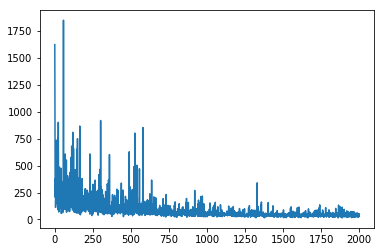

In [28]:
plt.figure()
plt.plot(losses_3)
plt.show()

## Training with embedding size = 6

In [29]:
epoch_range = 2000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 6

lstm_ae_4 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_4.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_4.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_4 = train_lstm(lstm_ae_4, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/2000], loss:2170.81128, avg:2170.81128
epoch [2/2000], loss:800.21265, avg:1485.51196
epoch [3/2000], loss:501.39978, avg:1157.47461
epoch [4/2000], loss:253.42528, avg:931.46228
epoch [5/2000], loss:116.03061, avg:768.37592
epoch [6/2000], loss:202.50032, avg:674.06329
epoch [7/2000], loss:151.32201, avg:599.38593
epoch [8/2000], loss:95.67068, avg:536.42157
epoch [9/2000], loss:118.84008, avg:490.02359
epoch [10/2000], loss:193.90602, avg:460.41187
epoch [11/2000], loss:270.76633, avg:270.40741
epoch [12/2000], loss:115.12225, avg:201.89835
epoch [13/2000], loss:180.26428, avg:169.78477
epoch [14/2000], loss:285.38910, avg:172.98117
epoch [15/2000], loss:314.07516, avg:192.78561
epoch [16/2000], loss:81.91348, avg:180.72694
epoch [17/2000], loss:238.63782, avg:189.45853
epoch [18/2000], loss:168.99916, avg:196.79137
epoch [19/2000], loss:307.79541, avg:215.68692
epoch [20/2000], loss:115.42349, avg:207.83865
epoch [21/2000], loss:84.38371, avg:189.20038
epoch [22/2000], loss

epoch [175/2000], loss:79.00807, avg:153.68698
epoch [176/2000], loss:55.11125, avg:153.63885
epoch [177/2000], loss:81.59328, avg:125.71193
epoch [178/2000], loss:181.48254, avg:114.88518
epoch [179/2000], loss:107.35423, avg:112.73264
epoch [180/2000], loss:148.14720, avg:118.01896
epoch [181/2000], loss:422.87039, avg:152.09834
epoch [182/2000], loss:246.91426, avg:160.15541
epoch [183/2000], loss:45.12282, avg:147.02455
epoch [184/2000], loss:123.35332, avg:149.09573
epoch [185/2000], loss:103.52677, avg:151.54761
epoch [186/2000], loss:113.65853, avg:157.40233
epoch [187/2000], loss:392.62183, avg:188.50519
epoch [188/2000], loss:94.18176, avg:179.77512
epoch [189/2000], loss:100.56194, avg:179.09587
epoch [190/2000], loss:48.19743, avg:169.10091
epoch [191/2000], loss:148.21846, avg:141.63571
epoch [192/2000], loss:93.46534, avg:126.29082
epoch [193/2000], loss:48.12307, avg:126.59084
epoch [194/2000], loss:99.19468, avg:124.17499
epoch [195/2000], loss:85.36668, avg:122.35897
ep

epoch [349/2000], loss:62.90423, avg:118.94865
epoch [350/2000], loss:208.43449, avg:115.26314
epoch [351/2000], loss:75.83457, avg:109.60995
epoch [352/2000], loss:63.14933, avg:111.65654
epoch [353/2000], loss:86.98870, avg:112.53439
epoch [354/2000], loss:77.48567, avg:110.20473
epoch [355/2000], loss:81.99191, avg:108.50427
epoch [356/2000], loss:34.66894, avg:85.04183
epoch [357/2000], loss:251.57220, avg:102.48196
epoch [358/2000], loss:46.77154, avg:98.98016
epoch [359/2000], loss:110.29893, avg:103.71963
epoch [360/2000], loss:49.33028, avg:87.80920
epoch [361/2000], loss:204.56046, avg:100.68180
epoch [362/2000], loss:57.73854, avg:100.14071
epoch [363/2000], loss:146.84468, avg:106.12632
epoch [364/2000], loss:70.77489, avg:105.45522
epoch [365/2000], loss:85.00388, avg:105.75643
epoch [366/2000], loss:89.17168, avg:111.20670
epoch [367/2000], loss:63.27888, avg:92.37738
epoch [368/2000], loss:81.50205, avg:95.85043
epoch [369/2000], loss:103.95033, avg:95.21556
epoch [370/20

epoch [525/2000], loss:61.14363, avg:115.96061
epoch [526/2000], loss:128.55779, avg:100.20207
epoch [527/2000], loss:78.05019, avg:98.15166
epoch [528/2000], loss:62.39485, avg:74.51086
epoch [529/2000], loss:49.80516, avg:70.65388
epoch [530/2000], loss:37.22436, avg:66.51273
epoch [531/2000], loss:44.80773, avg:66.16873
epoch [532/2000], loss:41.41757, avg:66.63991
epoch [533/2000], loss:170.28705, avg:76.17191
epoch [534/2000], loss:59.86460, avg:73.35530
epoch [535/2000], loss:57.17810, avg:72.95874
epoch [536/2000], loss:51.98137, avg:65.30110
epoch [537/2000], loss:228.49406, avg:80.34548
epoch [538/2000], loss:95.65908, avg:83.67191
epoch [539/2000], loss:65.27280, avg:85.21867
epoch [540/2000], loss:44.23813, avg:85.92004
epoch [541/2000], loss:56.90311, avg:87.12959
epoch [542/2000], loss:43.35565, avg:87.32340
epoch [543/2000], loss:31.85191, avg:73.47989
epoch [544/2000], loss:128.46577, avg:80.34000
epoch [545/2000], loss:71.20969, avg:81.74316
epoch [546/2000], loss:84.66

epoch [703/2000], loss:46.77131, avg:62.49457
epoch [704/2000], loss:46.54593, avg:63.14106
epoch [705/2000], loss:35.01109, avg:61.38057
epoch [706/2000], loss:45.75978, avg:60.43993
epoch [707/2000], loss:57.80271, avg:57.91764
epoch [708/2000], loss:46.31437, avg:57.33892
epoch [709/2000], loss:36.77545, avg:51.05665
epoch [710/2000], loss:38.20329, avg:47.18800
epoch [711/2000], loss:29.93612, avg:44.43093
epoch [712/2000], loss:56.96685, avg:44.00869
epoch [713/2000], loss:101.50433, avg:49.48199
epoch [714/2000], loss:214.50977, avg:66.27838
epoch [715/2000], loss:59.68186, avg:68.74546
epoch [716/2000], loss:38.34145, avg:68.00362
epoch [717/2000], loss:74.24356, avg:69.64771
epoch [718/2000], loss:65.99363, avg:71.61564
epoch [719/2000], loss:60.57401, avg:73.99548
epoch [720/2000], loss:44.14386, avg:74.58955
epoch [721/2000], loss:87.77531, avg:80.37346
epoch [722/2000], loss:102.75755, avg:84.95254
epoch [723/2000], loss:40.06858, avg:78.80896
epoch [724/2000], loss:47.74534

epoch [881/2000], loss:32.33187, avg:51.13330
epoch [882/2000], loss:60.49576, avg:51.98976
epoch [883/2000], loss:66.90403, avg:53.20205
epoch [884/2000], loss:31.40729, avg:50.50903
epoch [885/2000], loss:38.95994, avg:50.79060
epoch [886/2000], loss:45.22245, avg:50.08353
epoch [887/2000], loss:80.00159, avg:50.84370
epoch [888/2000], loss:31.14334, avg:48.29611
epoch [889/2000], loss:76.85895, avg:51.78623
epoch [890/2000], loss:32.50162, avg:49.58268
epoch [891/2000], loss:54.13473, avg:51.76297
epoch [892/2000], loss:41.77353, avg:49.89075
epoch [893/2000], loss:73.41882, avg:50.54223
epoch [894/2000], loss:61.81660, avg:53.58316
epoch [895/2000], loss:70.91085, avg:56.77825
epoch [896/2000], loss:66.64584, avg:58.92058
epoch [897/2000], loss:122.46530, avg:63.16695
epoch [898/2000], loss:51.44656, avg:65.19728
epoch [899/2000], loss:71.50705, avg:64.66209
epoch [900/2000], loss:54.43539, avg:66.85547
epoch [901/2000], loss:45.00496, avg:65.94249
epoch [902/2000], loss:57.75686, 

epoch [1058/2000], loss:29.21668, avg:44.95239
epoch [1059/2000], loss:79.09924, avg:47.34222
epoch [1060/2000], loss:19.39253, avg:45.65807
epoch [1061/2000], loss:149.92564, avg:57.31843
epoch [1062/2000], loss:48.13535, avg:57.72461
epoch [1063/2000], loss:90.29920, avg:63.36171
epoch [1064/2000], loss:34.28688, avg:59.27855
epoch [1065/2000], loss:35.77690, avg:59.47274
epoch [1066/2000], loss:34.33540, avg:58.46159
epoch [1067/2000], loss:30.13313, avg:55.06010
epoch [1068/2000], loss:49.76293, avg:57.11472
epoch [1069/2000], loss:29.44669, avg:52.14946
epoch [1070/2000], loss:49.76893, avg:55.18710
epoch [1071/2000], loss:66.45200, avg:46.83974
epoch [1072/2000], loss:47.30930, avg:46.75713
epoch [1073/2000], loss:54.47849, avg:43.17506
epoch [1074/2000], loss:45.25306, avg:44.27168
epoch [1075/2000], loss:40.14984, avg:44.70898
epoch [1076/2000], loss:40.74625, avg:45.35006
epoch [1077/2000], loss:40.54812, avg:46.39156
epoch [1078/2000], loss:60.41014, avg:47.45628
epoch [1079/

epoch [1233/2000], loss:41.35216, avg:47.86488
epoch [1234/2000], loss:30.36893, avg:47.99356
epoch [1235/2000], loss:26.15308, avg:45.98209
epoch [1236/2000], loss:39.05526, avg:45.80394
epoch [1237/2000], loss:33.66710, avg:44.21087
epoch [1238/2000], loss:46.15886, avg:44.50720
epoch [1239/2000], loss:42.07788, avg:38.10165
epoch [1240/2000], loss:24.93229, avg:36.17063
epoch [1241/2000], loss:40.52285, avg:36.84871
epoch [1242/2000], loss:71.76791, avg:39.60563
epoch [1243/2000], loss:54.43578, avg:40.91399
epoch [1244/2000], loss:48.81531, avg:42.75863
epoch [1245/2000], loss:72.92831, avg:47.43616
epoch [1246/2000], loss:39.42489, avg:47.47312
epoch [1247/2000], loss:55.38353, avg:49.64476
epoch [1248/2000], loss:52.48278, avg:50.27716
epoch [1249/2000], loss:86.50373, avg:54.71974
epoch [1250/2000], loss:34.43239, avg:55.66975
epoch [1251/2000], loss:198.25798, avg:71.44326
epoch [1252/2000], loss:33.40785, avg:67.60725
epoch [1253/2000], loss:108.84518, avg:73.04819
epoch [1254

epoch [1408/2000], loss:69.44199, avg:58.16856
epoch [1409/2000], loss:64.74261, avg:59.10622
epoch [1410/2000], loss:45.25665, avg:58.61539
epoch [1411/2000], loss:72.94601, avg:62.30266
epoch [1412/2000], loss:33.72068, avg:59.48539
epoch [1413/2000], loss:36.57205, avg:57.03969
epoch [1414/2000], loss:50.97050, avg:56.95182
epoch [1415/2000], loss:92.80077, avg:59.21428
epoch [1416/2000], loss:39.20132, avg:57.02057
epoch [1417/2000], loss:52.41973, avg:55.80723
epoch [1418/2000], loss:106.07186, avg:59.47022
epoch [1419/2000], loss:40.93498, avg:57.08946
epoch [1420/2000], loss:42.37964, avg:56.80176
epoch [1421/2000], loss:28.29304, avg:52.33646
epoch [1422/2000], loss:34.65844, avg:52.43024
epoch [1423/2000], loss:47.75441, avg:53.54847
epoch [1424/2000], loss:44.05553, avg:52.85698
epoch [1425/2000], loss:85.37209, avg:52.11411
epoch [1426/2000], loss:30.97462, avg:51.29144
epoch [1427/2000], loss:67.57035, avg:52.80650
epoch [1428/2000], loss:40.96346, avg:46.29566
epoch [1429/

epoch [1583/2000], loss:28.79020, avg:47.26176
epoch [1584/2000], loss:49.82182, avg:48.58152
epoch [1585/2000], loss:38.81054, avg:47.72180
epoch [1586/2000], loss:45.21276, avg:48.74289
epoch [1587/2000], loss:31.39665, avg:45.49564
epoch [1588/2000], loss:37.06067, avg:44.84920
epoch [1589/2000], loss:65.66467, avg:45.47977
epoch [1590/2000], loss:53.68296, avg:45.51047
epoch [1591/2000], loss:69.30888, avg:49.35480
epoch [1592/2000], loss:59.53949, avg:47.92886
epoch [1593/2000], loss:34.47402, avg:48.49725
epoch [1594/2000], loss:32.56794, avg:46.77186
epoch [1595/2000], loss:206.27155, avg:63.51796
epoch [1596/2000], loss:48.53130, avg:63.84981
epoch [1597/2000], loss:23.83031, avg:63.09318
epoch [1598/2000], loss:45.53962, avg:63.94108
epoch [1599/2000], loss:33.93903, avg:60.76851
epoch [1600/2000], loss:36.76412, avg:59.07662
epoch [1601/2000], loss:34.47487, avg:55.59322
epoch [1602/2000], loss:63.41470, avg:55.98074
epoch [1603/2000], loss:61.39641, avg:58.67299
epoch [1604/

epoch [1758/2000], loss:45.08070, avg:50.22062
epoch [1759/2000], loss:48.92967, avg:47.27621
epoch [1760/2000], loss:31.02320, avg:47.05421
epoch [1761/2000], loss:37.90003, avg:46.43479
epoch [1762/2000], loss:32.11266, avg:46.24552
epoch [1763/2000], loss:48.44310, avg:45.83764
epoch [1764/2000], loss:33.13642, avg:45.20138
epoch [1765/2000], loss:44.89624, avg:46.23714
epoch [1766/2000], loss:40.00230, avg:43.92425
epoch [1767/2000], loss:26.16387, avg:38.76882
epoch [1768/2000], loss:45.12421, avg:38.77317
epoch [1769/2000], loss:55.07093, avg:39.38729
epoch [1770/2000], loss:46.26508, avg:40.91148
epoch [1771/2000], loss:42.01288, avg:41.32277
epoch [1772/2000], loss:44.63867, avg:42.57537
epoch [1773/2000], loss:37.50329, avg:41.48139
epoch [1774/2000], loss:35.25463, avg:41.69321
epoch [1775/2000], loss:60.54716, avg:43.25830
epoch [1776/2000], loss:32.10318, avg:42.46839
epoch [1777/2000], loss:32.79823, avg:43.13182
epoch [1778/2000], loss:72.14500, avg:45.83390
epoch [1779/2

epoch [1933/2000], loss:54.99365, avg:54.71972
epoch [1934/2000], loss:66.04063, avg:58.76979
epoch [1935/2000], loss:35.26374, avg:48.97640
epoch [1936/2000], loss:21.04718, avg:47.15188
epoch [1937/2000], loss:53.01033, avg:48.38361
epoch [1938/2000], loss:40.00077, avg:45.99636
epoch [1939/2000], loss:31.14498, avg:40.00088
epoch [1940/2000], loss:27.54451, avg:39.72663
epoch [1941/2000], loss:29.29709, avg:39.16827
epoch [1942/2000], loss:22.89777, avg:38.12406
epoch [1943/2000], loss:60.70258, avg:38.69495
epoch [1944/2000], loss:32.13435, avg:35.30433
epoch [1945/2000], loss:39.04174, avg:35.68213
epoch [1946/2000], loss:42.73842, avg:37.85125
epoch [1947/2000], loss:63.98092, avg:38.94831
epoch [1948/2000], loss:45.15834, avg:39.46407
epoch [1949/2000], loss:43.17489, avg:40.66706
epoch [1950/2000], loss:57.76450, avg:43.68906
epoch [1951/2000], loss:78.60435, avg:48.61979
epoch [1952/2000], loss:28.89083, avg:49.21909
epoch [1953/2000], loss:44.35707, avg:47.58454
epoch [1954/2

In [30]:
torch.save(lstm_ae_4, 'models/visapy/lstm_6.pt') #Saving the autoencoder model

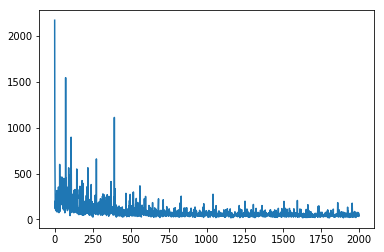

In [31]:
plt.figure()
plt.plot(losses_4)
plt.show()

-12.585175722837448
-5.438908487558365
-5.806689500808716
-13.391894787549973
-----------------
-4.850781321525574
-4.3462642431259155
-13.470976710319519
-0.6490263044834137
-----------------
-23.803589582443237
1.7175817489624023
-9.11217138171196
-3.584899663925171
-----------------
-4.856813907623291
-4.521026611328125
-2.4019293785095215
2.4143855571746826
-----------------
0.12980031967163086
0.3301384449005127
-16.077310994267464
-10.911545157432556
-----------------
-10.811004765331745
1.8450396358966827
-9.56816041469574
-8.197686672210693
-----------------
-5.248182773590088
16.33608168363571
-1.5160248577594757
11.084804683923721
-----------------


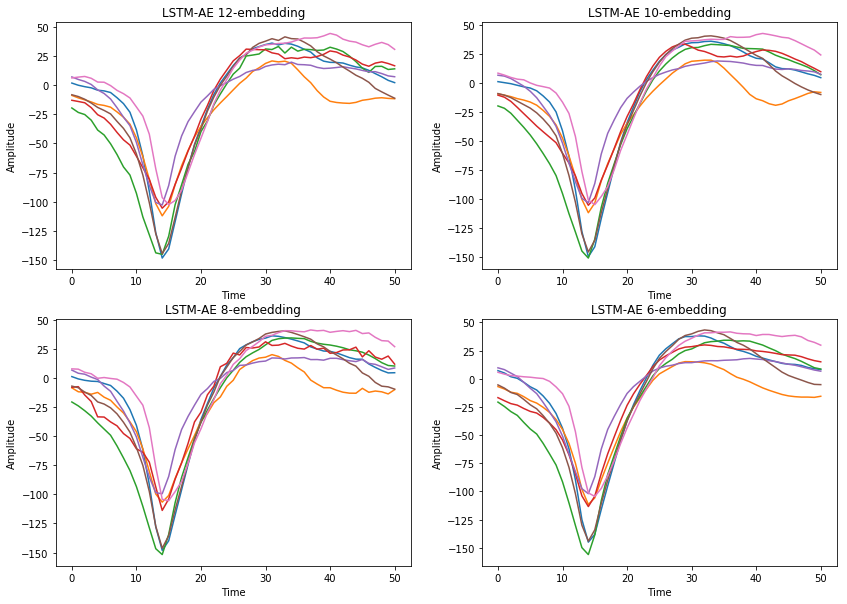

In [33]:
plt.figure(figsize=(14,10))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float()
    enc, o_1 = lstm_ae_1.forward(data)
    o_1 = (o_1.data).cpu().numpy()
    o_1 = o_1.reshape((51))
    print(np.sum(np.subtract(electrode_data_test[i, :], o_1)))
    enc, o_2 = lstm_ae_2.forward(data)
    o_2 = (o_2.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_2)))
    enc, o_3 = lstm_ae_3.forward(data)
    o_3 = (o_3.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_3)))
    enc, o_4 = lstm_ae_4.forward(data)
    o_4 = (o_4.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_4)))
    print('-----------------')
    plt.subplot(221)
    plt.plot(o_1)
    plt.title('LSTM-AE 12-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(222)
    plt.plot(o_2)
    plt.title('LSTM-AE 10-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(223)
    plt.plot(o_3)
    plt.title('LSTM-AE 8-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(224)
    plt.plot(o_4)
    plt.title('LSTM-AE 6-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()

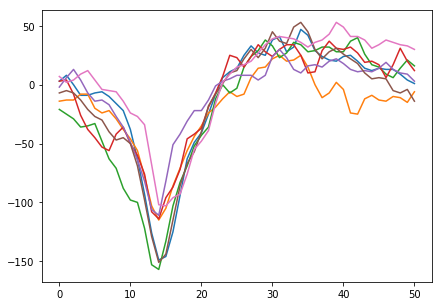

In [35]:
plt.figure(figsize=(7,5))
for i in [11, 290, 3490, 1098, 2707, 9, 871]:
    plt.plot(electrode_data_test[i, :])
plt.show()

# ---------------- LOAD MODELS TO USE -------------------

In [ ]:
# train_lim = int(0.8*electrode_data.shape[0])
# electrode_data_train = electrode_data[:train_lim, :]
# electrode_data_test = electrode_data[train_lim:, :]

# print("Training Datasize:", electrode_data_train.shape)
# print("Test Datasize:", electrode_data_test.shape)

### Loading the models

In [ ]:
# Make sure to execute autoencoder model code before executing this

lstm_ae_1 = torch.load('models/visapy/lstm_12.pt')
lstm_ae_2 = torch.load('models/visapy/lstm_10.pt')
lstm_ae_3 = torch.load('models/visapy/lstm_8.pt')
lstm_ae_4 = torch.load('models/visapy/lstm_6.pt')

In [ ]:
# lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
# inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
# #inputs = torch.from_numpy(inputs).float()

# # initialize the hidden state.
# hidden = (torch.randn(1, 1, 3),
#           torch.randn(1, 1, 3))

In [ ]:
# print(inputs)
# print('\n\n')
# print(hidden)

In [ ]:
# inputs = torch.cat(inputs).view(len(inputs), 1, -1)
# #inputs = inputs.view(1, 1, -1)

In [ ]:
# inputs = inputs.view(15, -1)
# print(inputs)
# inputs = inputs.view(3, 1, -1)
# print(inputs)

In [ ]:
# hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
# out, hidden = lstm(inputs, hidden)
# print(out)
# print(hidden)

In [ ]:
# for i in inputs:
#     # Step through the sequence one element at a time.
#     # after each step, hidden contains the hidden state.
#     out, hidden = lstm(i.view(1, 1, -1), hidden)
#     print(out)